In [1]:
# Import the dependencies
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt


# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

import pandas as pd
import numpy as np
import csv
import os
import seaborn as sns
from datetime import datetime as dt, timedelta


# Climate Analysis and Exploration

In [2]:
# Create an engine to a SQLite database file called `hawaii.sqlite`
engine = create_engine("sqlite:///hawaii.sqlite", echo = False)

# Explore Database

In [3]:
# Get the tables in the Hawaii Database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [4]:
# Get a list of column names and types for Measurements Table
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])
# columns

In [5]:
# Get a list of column names and types for Stations Table
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])
# columns

# Reflect and Query

In [6]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys() # Retrieve the names of the tables in the database

['measurement', 'station']

In [7]:
Measurements = Base.classes.measurement # Map measurements class
Stations = Base.classes.station # Map stations class

In [8]:
session = Session(engine)

# Precipitation Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data.
# Select only the date and prcp values.
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Plot the results using the DataFrame plot method.

In [26]:
# Retrieve Latest Date
latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()[0]
format_latest_date = dt.strptime(latest_date,"%Y-%m-%d")

# Design a query to retrieve the last 12 months of precipitation data.
sel = [Measurements.date, func.avg(Measurements.prcp)]
last_year_date = format_latest_date - timedelta(days=365)  
prcp_data = session.query(*sel).\
    filter((Measurements.date >= last_year_date)).\
    group_by(Measurements.date).\
    order_by(Measurements.date).all()
    

In [11]:

# Create the Dataframe for storing the SQL query results for last 12 months of preceipitation data
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True) 
prcp_df.head()


,Precipitation
Date,
2016-08-24,1.332857
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.053333
2016-08-28,0.516667


# Precipitation Analysis Plot

<IPython.core.display.Javascript object>


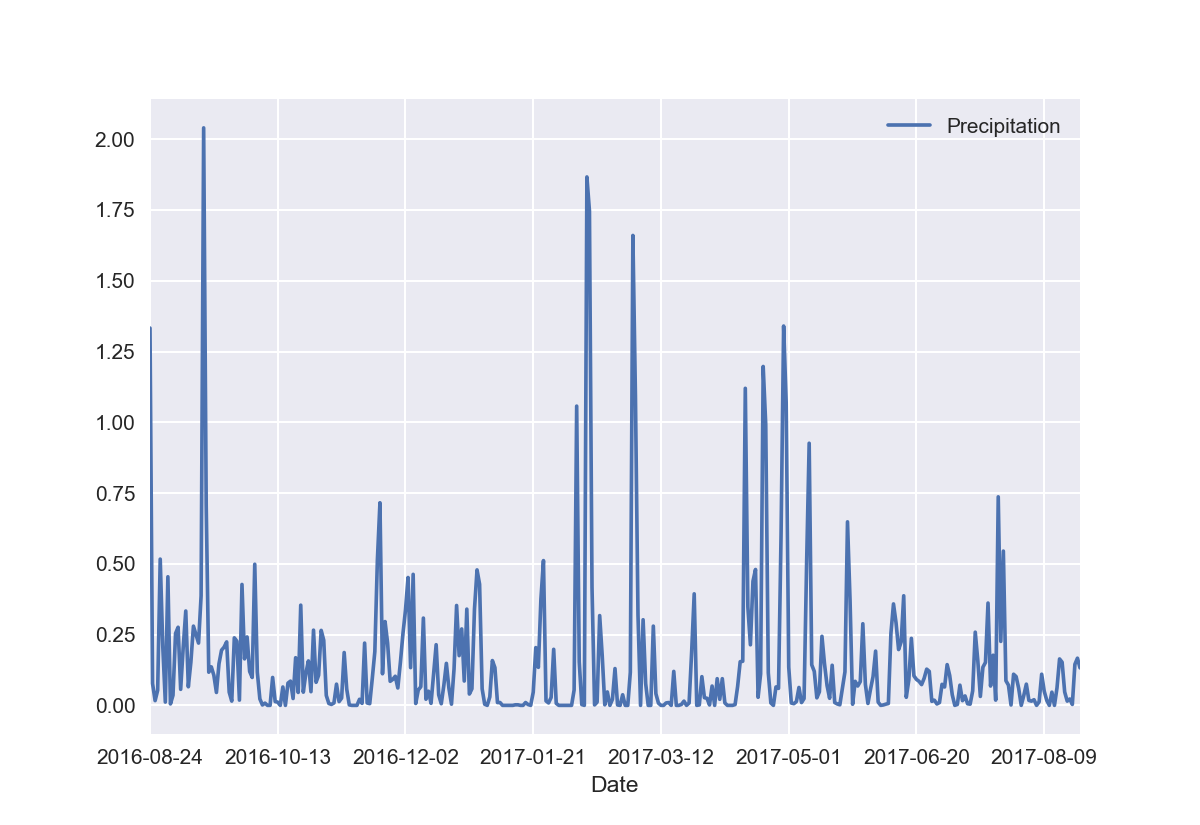

In [12]:
# Create the plot
prcp_df.plot()
plt.savefig("Images/precipitation_analysis.png")
plt.show()

# Summary Statistics for Precipitation Data

In [13]:
#Use Pandas to print the summary statistics for the precipitation data.
prcp_df.describe()

,Precipitation
count,365.000000
mean,0.156103
std,0.275657
min,0.000000
25%,0.008571
50%,0.065000
75%,0.175714
max,2.040000


# Station Analysis

In [14]:
# Design a query to calculate the total number of stations.
station_count = session.query(Stations.id).count()
print ("Total Number of Stations are: "+ str(station_count))

Total Number of Stations are: 9


In [15]:
# Query for finding the most active stations
# List the stations and observation counts in descending order
sel = [Measurements.station, func.count(Measurements.tobs)]
active_stations_data = session.query(*sel).group_by(Measurements.station).order_by(desc(func.count(Measurements.tobs))).all()
active_stations_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
print ("The station with the highest number of observations is: " + str(active_stations_data[0]))

The station with the highest number of observations is: ('USC00519281', 2772)


In [17]:
highest_station = active_stations_data[0][0] #Storing the highest station as a variable
highest_station

'USC00519281'

In [18]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

sel = [Measurements.tobs]
temperature_data = session.query(*sel).\
    filter(Measurements.date >= last_year_date).\
    filter(Measurements.station == highest_station).all()

# Plot the results as a histogram with bins=12.

In [19]:
# Creating a list of items 'tobs_data' from our initial mulitdimensional array 'temperature_data'

tobs_data = []
for row in temperature_data:
    tobs_data.append(row[0])

<IPython.core.display.Javascript object>


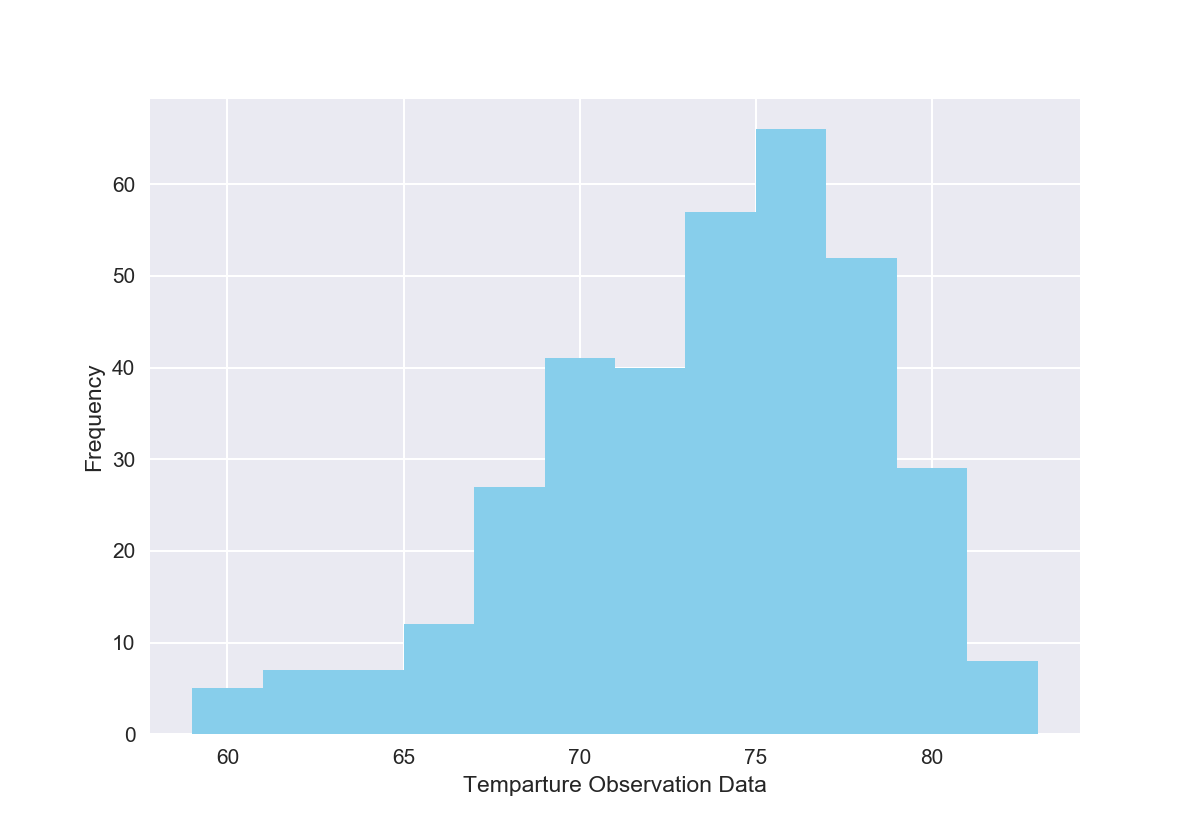

In [20]:
plt.hist(tobs_data, bins=12, label='tobs', color = 'skyblue')
plt.xlabel("Temparture Observation Data")
plt.ylabel("Frequency")
plt.savefig("Images/station_analysis.png")
plt.show()

# Code for Temperature Analysis

In [21]:
#Temperature Analysis
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
#Plot the min, avg, and max temperature from your previous query as a bar chart.
#Use the average temperature as the bar height.
#Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [22]:
def calc_temp(start_date, end_date):
    Start_Date = dt.strptime(start_date, "%Y-%m-%d")
    Start_Date = Start_Date.replace(Start_Date.year - 1)
    End_Date = dt.strptime(end_date, "%Y-%m-%d")
    End_Date = End_Date.replace(End_Date.year - 1)
    
    #Collect all the dates between start date and end date
    delta = End_Date - Start_Date
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(Start_Date + timedelta(days=i))
       
    #Converting to stings
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
       
   #Calculate Average Tempareure , Min and Maximum temperatures within the date range    
    temp_avg = session.query(func.avg(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
       
    return temp_avg, temp_min, temp_max

    

In [23]:
start_date = input("Please enter your trip's start date in YYYY-MM-DD: ")
end_date = input ("Please enter your trip's end date in YYYY-MM-DD: ")

Please enter your trip's start date in YYYY-MM-DD: 2018-04-01
Please enter your trip's end date in YYYY-MM-DD: 2018-04-10


In [24]:
trip_analysis = calc_temp(start_date, end_date)

tavg = trip_analysis[0]
tmin = trip_analysis[1]
tmax = trip_analysis[2]

<IPython.core.display.Javascript object>


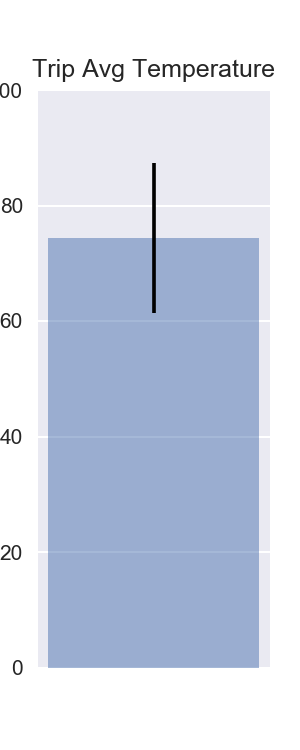

In [25]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.

# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

# Plot Bar chart 
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temperature")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_analysis.png")
plt.show()